#Environment Setup

In [ ]:
!git clone https://github.com/phantomcorn/artemis
%cd artemis
!pip3 install -e .
%cd ..
!git clone https://github.com/facebookresearch/audiocraft/
%cd audiocraft
!pip install -e .
%cd ..

Cloning into 'artemis'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 244 (delta 4), reused 7 (delta 2), pack-reused 231
Receiving objects: 100% (244/244), 100.08 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/artemis
Obtaining file:///content/artemis
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 15.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_

/content


##Imports

In [ ]:
%cd artemis
from PIL import Image
import torch
import json
import numpy as np
import random

from artemis.in_out.basics import pickle_data
from artemis.in_out.arguments import parse_test_speaker_arguments
from artemis.in_out.neural_net_oriented import torch_load_model, load_saved_speaker, seed_torch_code
from artemis.neural_models.attentive_decoder import negative_log_likelihood
from artemis.captioning.sample_captions import versatile_caption_sampler, captions_as_dataframe
from artemis.in_out.datasets import sub_index_affective_dataloader
from artemis.in_out.datasets import default_grounding_dataset_from_affective_loader
from artemis.in_out.datasets import custom_grounding_dataset_similar_to_affective_loader

import pandas as pd
from artemis.in_out.basics import unpickle_data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%cd ..
#------------------------------------------------------------------------------#
%cd audiocraft
import os
import sys
from torch.utils.data import DataLoader
import torchaudio
from audiocraft.models import MusicGen
from audiocraft.data.audio import audio_write
from audiocraft.modules.conditioners import ConditioningAttributes, WavCondition, ClassifierFreeGuidanceDropout
import soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
%cd ..
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/content/artemis


/content/artemis/artemis/in_out/datasets.py:34: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if img.mode is not 'RGB':
/content/artemis/artemis/in_out/datasets.py:69: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.rgb_only and img.mode is not 'RGB':


/content
/content/audiocraft
/content


In [ ]:
import torch
import random
import numpy as np

In [ ]:
def seed_torch_code(seed, strict=False):
    """Control pseudo-randomness for reproducibility.
    :param manual_seed: (int) random-seed
    :param strict: (boolean) if True, cudnn operates in a deterministic manner
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if strict:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
seed_torch_code(seed)

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"

#Image-Text

##Build sample dataset from image-music pair

In [ ]:
art_style = []
painting = []
emotion = []
utterance = []
repetition = []
split = []
tokens = []
tokens_len = []
utterance_spelled = []
tokens_encoded = []
emotion_label = []


for sample in df.iterrows():
  img_fname = sample[1].IMG_FILE
  img_subdir = f'{sample[1].img_from_folder}/images'
  img_path = f'{PROJECT_PATH}/IMEMNet/{img_subdir}/{img_fname}.jpg'

  save_path = f'{PROJECT_PATH}/Artemis/wikiart/Sample/{img_fname}.jpg'
  if not os.path.exists(save_path): #save to Artemis folder if not exist (location used for captioning)
    img = Image.open(img_path).convert('RGB')
    img.save(save_path)

  art_style.append("Sample")
  painting.append(img_fname)
  split.append("test")
  emotion.append("something else") #placeholder
  utterance.append("TEST") #placeholder
  repetition.append(1) #placeholder
  tokens.append(["TEST"]) #placeholder
  tokens_len.append(1)    #placeholder
  utterance_spelled.append("test") #placeholder
  tokens_encoded.append([0]) #placeholder
  emotion_label.append(1) #placeholder

In [ ]:
records = {"art_style": art_style,
           "painting": painting,
           "emotion": emotion,
           "utterance": utterance,
           "repetition": repetition,
           "split": split,
           "tokens": tokens,
           "tokens_len": tokens_len,
           "utterance_spelled": utterance_spelled,
           "tokens_encoded": tokens_encoded,
           "emotion_label": emotion_label}
artemis_subsample_df = pd.DataFrame(records)
print(artemis_subsample_df.head())
artemis_subsample_df.to_csv(f'{PROJECT_PATH}/Artemis/preprocessed_data/for_model/artemis_preprocessed.csv')

  art_style                     painting         emotion utterance  \
0    Sample           aumxa6oyo44xizmdtm  something else      TEST   
1    Sample  COCO_train2014_000000184589  something else      TEST   
2    Sample       frame_d8vvnvutq7jpta2z  something else      TEST   
3    Sample             Landscapes_081_h  something else      TEST   
4    Sample       frame_axnd5766lxvfw77i  something else      TEST   

   repetition split  tokens  tokens_len utterance_spelled tokens_encoded  \
0           1  test  [TEST]           1              test            [0]   
1           1  test  [TEST]           1              test            [0]   
2           1  test  [TEST]           1              test            [0]   
3           1  test  [TEST]           1              test            [0]   
4           1  test  [TEST]           1              test            [0]   

   emotion_label  
0              1  
1              1  
2              1  
3              1  
4              1  


##For presentation images

In [ ]:
fnames = list(map(lambda x : x.split(".")[0],os.listdir(f'{PROJECT_PATH}/Artemis/wikiart/ImAudible/')))
fnames

['spiderman',
 'starry_night',
 'woman_in_blue',
 'distracted_bf_meme',
 'the_kiss',
 'tn',
 'pt',
 'p',
 't',
 'n',
 'm',
 'kk',
 'lr',
 'rock',
 'igor']

In [ ]:
art_style = []
painting = []
emotion = []
utterance = []
repetition = []
split = []
tokens = []
tokens_len = []
utterance_spelled = []
tokens_encoded = []
emotion_label = []

for img_fname in fnames:
    art_style.append("ImAudible")
    painting.append(img_fname)
    split.append("test")
    emotion.append("something else") #placeholder
    utterance.append("TEST") #placeholder
    repetition.append(1) #placeholder
    tokens.append(["TEST"]) #placeholder
    tokens_len.append(1)    #placeholder
    utterance_spelled.append("test") #placeholder
    tokens_encoded.append([0]) #placeholder
    emotion_label.append(1) #placeholder

In [ ]:
records = {"art_style": art_style,
           "painting": painting,
           "emotion": emotion,
           "utterance": utterance,
           "repetition": repetition,
           "split": split,
           "tokens": tokens,
           "tokens_len": tokens_len,
           "utterance_spelled": utterance_spelled,
           "tokens_encoded": tokens_encoded,
           "emotion_label": emotion_label}
artemis_subsample_df = pd.DataFrame(records)
print(artemis_subsample_df.head())
artemis_subsample_df.to_csv(f'{PROJECT_PATH}/Artemis/preprocessed_data/for_model/artemis_preprocessed.csv')

   art_style            painting         emotion utterance  repetition split  \
0  ImAudible           spiderman  something else      TEST           1  test   
1  ImAudible        starry_night  something else      TEST           1  test   
2  ImAudible       woman_in_blue  something else      TEST           1  test   
3  ImAudible  distracted_bf_meme  something else      TEST           1  test   
4  ImAudible            the_kiss  something else      TEST           1  test   

   tokens  tokens_len utterance_spelled tokens_encoded  emotion_label  
0  [TEST]           1              test            [0]              1  
1  [TEST]           1              test            [0]              1  
2  [TEST]           1              test            [0]              1  
3  [TEST]           1              test            [0]              1  
4  [TEST]           1              test            [0]              1  


## Image Captioning

In [ ]:
ARTEMIS_MODEL_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/models/vanilla_SAT_speaker"
SPEAKER_SAVED_ARGS = ARTEMIS_MODEL_PATH + "/config.json.txt"
SPEAKER_CHECKPOINT = ARTEMIS_MODEL_PATH + "/checkpoints/best_model.pt"
SPLIT = "test"
MAX_UTTERANCE_LEN = 10
OUT_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/inference/output/output.pkl"
SUBSAMPLE_DATA = -1 #if not -1, will subsample the underlying dataset and will annotated only this many images.
CUSTOM_DATA_CSV = None #if you want to annotate your own set of images e.g. adding manual emotional grounding. See code for what this csv should look like.
COMPUTE_NLL = False
SAMPLING_CONFIG_FILE = "/content/artemis/artemis/data/speaker_sampling_configs/selected_hyper_params.json.txt"
IMG2EMO_CHECKPOINT = None
N_WORKERS = None

In [ ]:
# Load pretrained speaker & its corresponding train-val-test data. If you do not provide a
# custom set of images to annotate. Then based on the -split you designated it will annotate this data.
speaker, epoch, data_loaders = load_saved_speaker(SPEAKER_SAVED_ARGS, SPEAKER_CHECKPOINT,
                                                  with_data=True, verbose=True)
speaker = speaker.to(device)
eos = speaker.decoder.vocab.eos
working_data_loader = data_loaders[SPLIT]

if MAX_UTTERANCE_LEN is None:
    # use the maximum length in the underlying split.
    def utterance_len(tokens, eos=eos):
        return np.where(np.asarray(tokens) == eos)[0][0] -1 # -1 to remove sos
    MAX_UTTERANCE_LEN = working_data_loader.dataset.tokens.apply(utterance_len).max()

use_custom_dataset = False
if CUSTOM_DATA_CSV is not None:
    use_custom_dataset = True

if COMPUTE_NLL and not use_custom_dataset:
    print('Computing Negative Log Likelihood of ground-truth annotations:')
    nll = negative_log_likelihood(speaker, working_data_loader, device)
    print('{} NLL: {}'.format(SPLIT, nll))

img2emo_clf = None
if IMG2EMO_CHECKPOINT:
    img2emo_clf = torch_load_model(IMG2EMO_CHECKPOINT, map_location=device)

if use_custom_dataset:
    annotate_loader = custom_grounding_dataset_similar_to_affective_loader(CUSTOM_DATA_CSV,
                                                                            working_data_loader, N_WORKERS)
else:
    # removes duplicate images and optionally uses img2emo_clf to create a grounding emotion.
    annotate_loader = default_grounding_dataset_from_affective_loader(working_data_loader, img2emo_clf,
                                                                      device, N_WORKERS)

if SUBSAMPLE_DATA != -1:
    sids = np.random.choice(len(annotate_loader.dataset.image_files), SUBSAMPLE_DATA)
    annotate_loader = sub_index_affective_dataloader(annotate_loader, sids)

with open(SAMPLING_CONFIG_FILE) as fin:
    sampling_configs = json.load(fin)

print('Loaded {} sampling configurations to try.'.format(len(sampling_configs)))
optional_params = {'max_utterance_len': MAX_UTTERANCE_LEN, 'drop_unk': True, 'drop_bigrams': True}

final_results = []
for config in sampling_configs:
    for param in optional_params.keys():
        if param not in config:
          config[param] = optional_params[param]
    print('Sampling with configuration: ', config)

    captions_predicted, attn_weights = versatile_caption_sampler(speaker, annotate_loader, device, **config)
    df = captions_as_dataframe(annotate_loader.dataset, captions_predicted, wiki_art_data=not use_custom_dataset)
    final_results.append([config, df])
    print('Done.')

pickle_data(OUT_PATH, final_results)
print(captions_predicted)


Loading saved speaker trained with parameters:
{'atn_cover_img_alpha': 1,
 'atn_spatial_img_size': None,
 'attention_dim': 512,
 'batch_size': 128,
 'data_dir': '/content/drive/MyDrive/Colab '
             'Notebooks/Project/Artemis/preprocessed_data/for_model',
 'dataset': 'artemis',
 'debug': False,
 'decoder_lr': 0.0005,
 'dropout_rate': 0.1,
 'emo_grounding_dims': [9, 9],
 'encoder_lr': 0.0001,
 'fine_tune_data': None,
 'gpu': '1',
 'img_dim': 256,
 'img_dir': '/content/drive/MyDrive/Colab Notebooks/Project/Artemis/wikiart',
 'lanczos': True,
 'log_dir': '/content/drive/MyDrive/Colab '
            'Notebooks/Project/Artemis/models/vanilla_SAT_speaker',
 'lr_patience': 2,
 'max_train_epochs': 50,
 'num_workers': 10,
 'random_seed': 2021,
 'resume_path': None,
 'rnn_hidden_dim': 512,
 'save_each_epoch': False,
 'teacher_forcing_ratio': 1,
 'train_patience': 5,
 'use_emo_grounding': False,
 'use_timestamp': True,
 'vis_encoder': 'resnet34',
 'word_embedding_dim': 128}
Using a vocabula

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.1MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in curren

Loading speaker model at epoch 7.
Loaded 10 utterances
Loaded 1 sampling configurations to try.
Sampling with configuration:  {'sampling_rule': 'beam', 'temperature': 0.3, 'beam_size': 5, 'max_utterance_len': 10, 'drop_unk': True, 'drop_bigrams': True}


  0%|          | 0/10 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Done.
["the man 's face looks like he is looking at me", 'the sunset is very calming and the colors are very warm and inviting', 'the blue and white colors are calming and soothing', 'the grey sky and the dark blue sky make me feel sad', 'the woman looks like she is having a good time', 'the colors are very warm and inviting', 'the figures are very detailed and realistic', "the man 's face looks like he is looking at me", 'the trees look like they are glowing in the wind', 'the painting is very abstract and the colors are very pleasing']


In [ ]:
df.to_csv(f'{PROJECT_PATH}/Artemis/imaudible_caption.csv', index=False) #Save

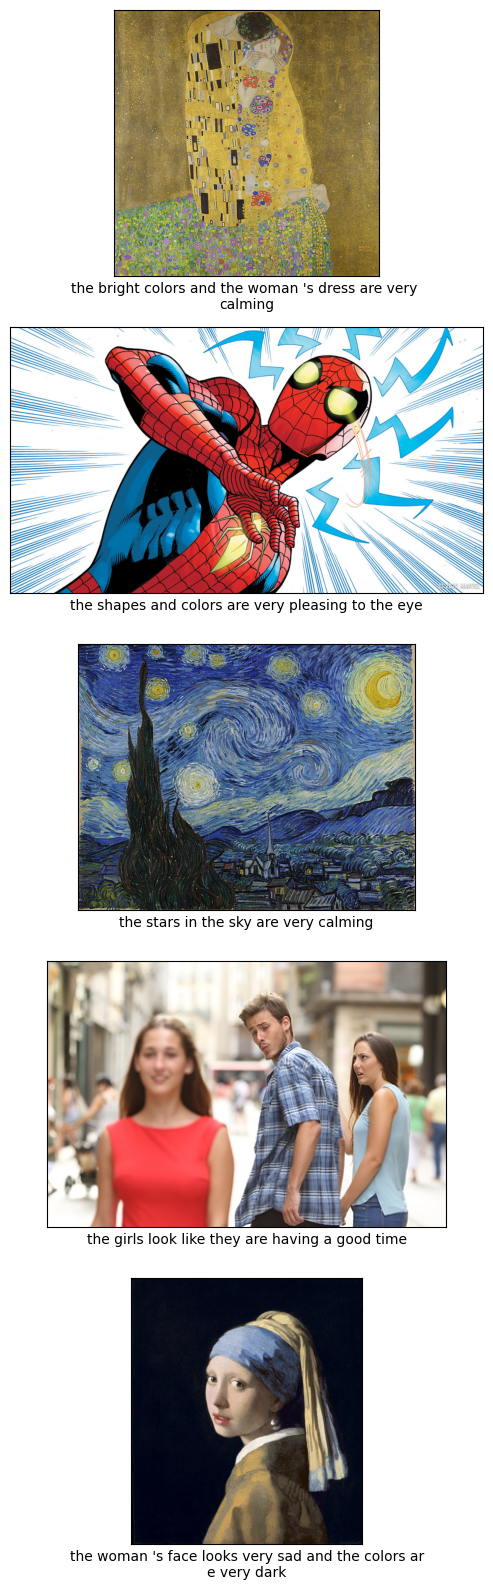

In [ ]:
num_to_show = 5

output_file = "/content/drive/MyDrive/Colab Notebooks/Project/Artemis/inference/output/output.pkl"
data = unpickle_data(output_file)
df = next(data)[0][1]



fig, ax = plt.subplots(num_to_show,figsize=(16, 16))
line_break = 50
for i,sample in enumerate(df.sample(num_to_show).iterrows()):
  img_path = f'/content/drive/MyDrive/Colab Notebooks/Project/Artemis/wikiart/Eval/{sample[1].painting}.jpg'

  caption = sample[1].caption
  caption = '\n'.join([caption[i:i+line_break] for i in range(0, len(caption), line_break)]) #add line breaks

  img = mpimg.imread(img_path)
  ax[i].imshow(img)
  ax[i].set_yticks([])
  ax[i].set_xticks([])


  ax[i].set_xlabel(caption)
  # plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
fig.tight_layout()





#[Optional] Stopwords removal

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopWords = set(stopwords.words('english'))

artemis_stop_words = ["look", "looks", "like"]
def swr(s):
  words = s.caption.split(" ")
  wordsFiltered = [w for w in words if w.lower() not in stopWords]
  wordsFiltered = [w for w in wordsFiltered if w.lower() not in artemis_stop_words]
  s.caption = " ".join(wordsFiltered)
  return s

captions = pd.read_csv(f'{PROJECT_PATH}/Artemis/imaudible_caption.csv')
captions_swr = captions.apply(swr, axis=1)
captions_swr.to_csv(f'{PROJECT_PATH}/Artemis/imaudible_caption_swr.csv', index=False)


#Text-Sound

In [ ]:
fnames = list(map(lambda x : x.split(".")[0],os.listdir(f'{PROJECT_PATH}/Artemis/random_similar_output')))
fnames

[]

In [ ]:
df = pd.read_csv(f'{PROJECT_PATH}/Final/imaudible_caption_swr.csv')

# already_generated_fnames = os.listdir(f'{PROJECT_PATH}/Audible-Visual/random_similar_output')
# already_generated_fnames = list(map(lambda fnames: fnames.split(".")[0], already_generated_fnames))
# df = df[~df.painting.isin(already_generated_fnames)]
df.head()

,art_style,painting,grounding_emotion,caption
0,Imaudible,igor,NaN,man 's face looking
1,Imaudible,kk,NaN,sunset calming colors warm inviting
2,Imaudible,lr,NaN,blue white colors calming soothing
3,Imaudible,m,NaN,grey sky dark blue sky make feel sad
4,Imaudible,n,NaN,woman good time


In [ ]:
model = MusicGen.get_pretrained('medium', device=device)
model.set_generation_params(duration=16)  # generate 8 seconds.

/usr/local/lib/python3.10/dist-packages/audiocraft/models/musicgen.py:80: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-medium
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


state_dict.bin:   0%|          | 0.00/3.68G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

compression_state_dict.bin:   0%|          | 0.00/236M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
captions = df.caption.tolist()
d_captions = []
step = 5
#split into 2d array of 5 caption per array
for i in range(0,len(captions), step):
  d_captions.append(captions[i:i+step])
len(d_captions)

2

In [ ]:
for idx_captions, captions in enumerate(d_captions):

  wavs = model.generate(captions)  # generates 5 samples.

  for idx_wav, one_wav in enumerate(wavs):

    df_idx = (step*idx_captions + idx_wav)
    painting_name = df.iloc[df_idx].painting
    # Will save under {idx}.wav, with loudness normalization at -14 db LUFS.
    audio_write(f'{PROJECT_PATH}/Final/{painting_name}',
                one_wav.cpu(),
                model.sample_rate,
                strategy="loudness")

    print(f'{painting_name} saved!')

CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/igor happening with proba (a bit of clipping is okay): 0.000197265631868504 maximum scale:  1.4040976762771606


igor saved!
kk saved!


CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/kk happening with proba (a bit of clipping is okay): 0.0016796875279396772 maximum scale:  1.5390592813491821


lr saved!
m saved!


CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/m happening with proba (a bit of clipping is okay): 4.2968749767169356e-05 maximum scale:  1.048271656036377
CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/n happening with proba (a bit of clipping is okay): 0.006720703095197678 maximum scale:  2.50101375579834


n saved!
p saved!
pt saved!


CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/pt happening with proba (a bit of clipping is okay): 3.9062499126885086e-05 maximum scale:  1.0176821947097778


rock saved!
t saved!
tn saved!


CLIPPING /content/drive/MyDrive/Colab Notebooks/Project/Final/tn happening with proba (a bit of clipping is okay): 0.000357421871740371 maximum scale:  1.2153290510177612


#Result

In [ ]:
from IPython.display import Audio, display


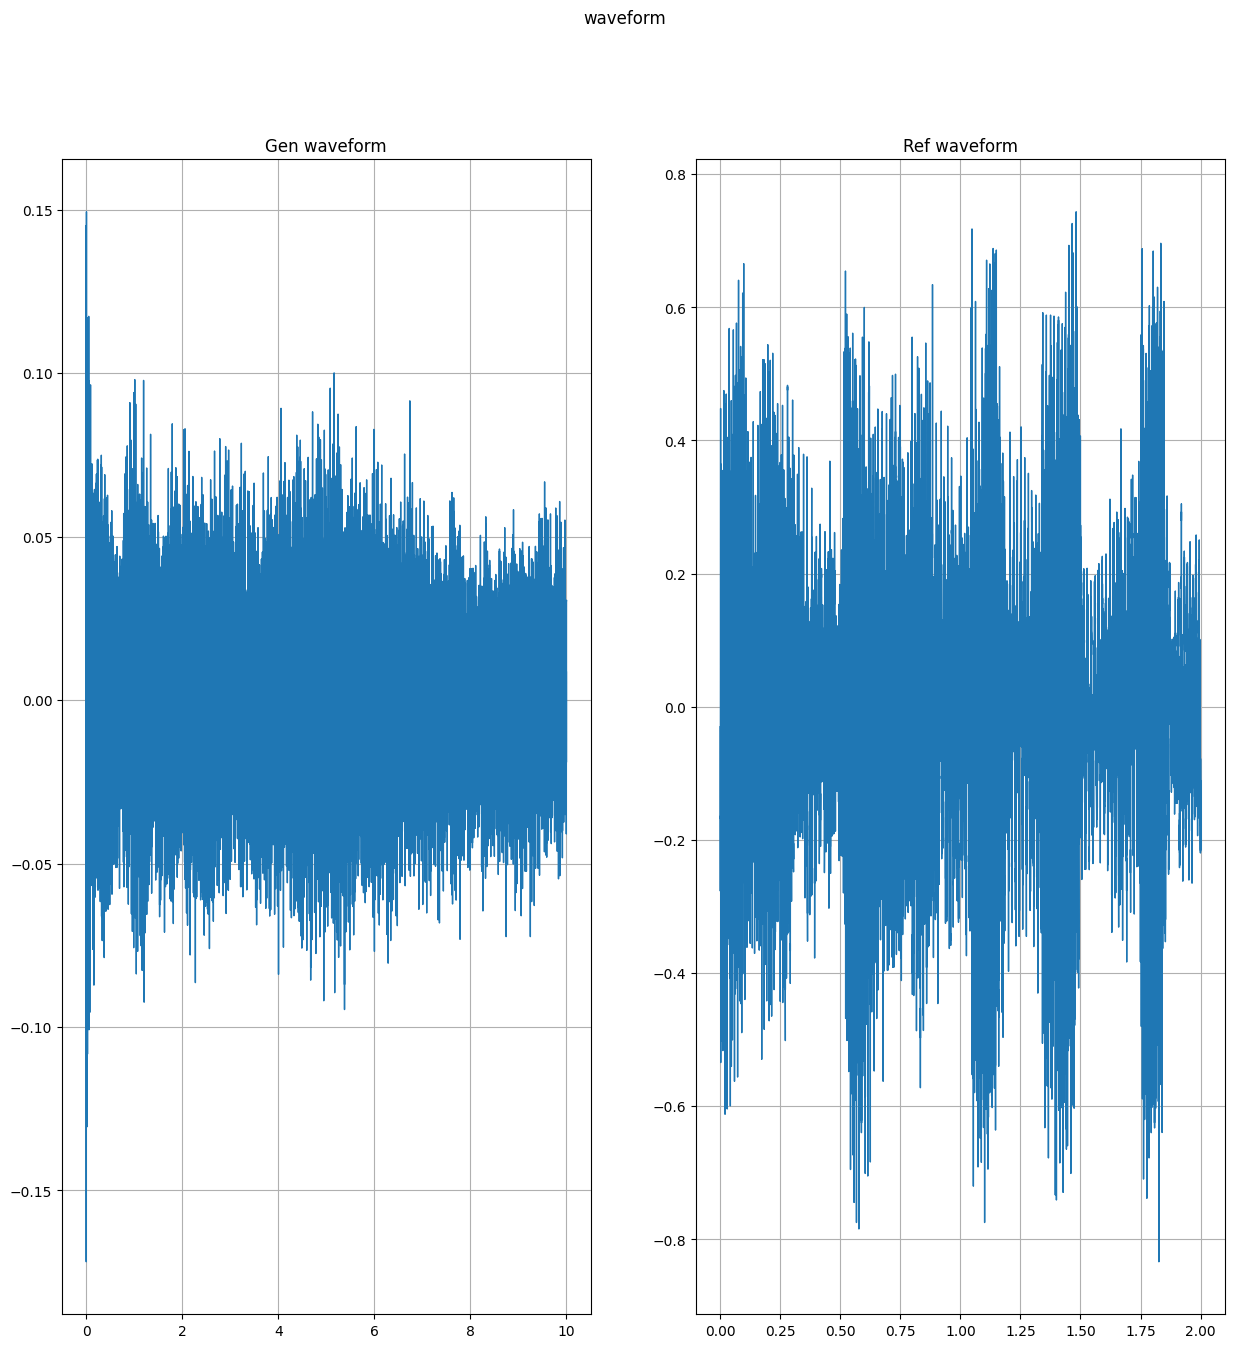

In [ ]:
def load_wave(idx):
    img_name = prompt_df.iloc[idx].painting
    gen_audio_path = f'{gen_audio_dir}/{img_name}.wav'
    gen_waveform, gen_sr = torchaudio.load(gen_audio_path)

    pair_data = pairs_df[pairs_df.IMG_FILE == img_name].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
    ref_audio_path = f'{ref_audio_dir}/{pair_data.WAV_FILE}.wav'
    ref_waveform, ref_sr = torchaudio.load(ref_audio_path)

    return gen_waveform, gen_sr, ref_waveform, ref_sr

def plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr):

    gen_waveform = gen_wave.numpy()
    _, gen_num_frames = gen_waveform.shape

    ref_waveform = ref_wave.numpy()
    _, ref_num_frames = ref_waveform.shape

    gen_time_axis = torch.arange(0, gen_num_frames) / gen_sr
    ref_time_axis = torch.arange(0, ref_num_frames) / ref_sr

    waveform = [gen_waveform, ref_waveform]
    time_axis = [gen_time_axis, ref_time_axis]
    title = ["Gen waveform", "Ref waveform"]

    figure, axes = plt.subplots(1,2, figsize=(15,15))

    for i,wave in enumerate(waveform):
        axes[i].plot(time_axis[i], wave[0], linewidth=1)
        axes[i].grid(True)
        axes[i].set_title(title[i])


    figure.suptitle("waveform")

gen_wave, gen_sr, ref_wave, ref_sr = load_wave(1)
plot_gen_waveform(gen_wave, gen_sr, ref_wave, ref_sr)


#Evaluation/Analysis

##Frechet Audio Distance

In [ ]:
!pip install frechet_audio_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of laion-clap to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import torchaudio
import os
import random
import torch
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Project"

In [ ]:
gen_audio_dir = f'{PROJECT_PATH}/Audible-Visual/musicgen/most_similar_output/1s_audio_every_500ms'
bg_audio_dir = f'{PROJECT_PATH}/FMA_INSTR/1s_audio_every_500ms'
bg_embs_save_path = f'{PROJECT_PATH}/Audible-Visual/fma_instr_bg_emb.npy'

In [ ]:
from frechet_audio_distance import FrechetAudioDistance

# to use `vggish`
frechet = FrechetAudioDistance(
    model_name="vggish",
    sample_rate=16000,
    use_pca=False,
    use_activation=False,
    verbose=False
)

fad = frechet.score(
   bg_audio_dir,
    gen_audio_dir,
    bg_embs_save_path,
    None
)

Background: MusicCaps


In [ ]:
fad

7.702688889802636203

Background: FMA

In [ ]:
fad

4.980826974146047411

Background : FMA Instrumental

In [ ]:
fad

2.3971147014162301307

##KL Divergence (Most similar)

We compare the probability distribution obtained from passing the audio file into a Music-genre classifier (https://huggingface.co/SeyedAli/Musical-genres-Classification-Hubert-V1)

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, Audio
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/most_similar_subsample.csv')

Build dataset

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/musicgen/most_similar_output/8s_audio'
gen_fnames = os.listdir(gen_audio_subdir)
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  #Get corresponding ref audio name
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

50


In [ ]:
audio_dataset[0]['ref_audio']['array'].shape

(32000,)

In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl_avg = 0
kl = []
correct = 0
incorrect = 0
similarity = []
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)
    ref_genre = ref_audio_dist.argmax(-1).item()

    gen_audio = two_second_window(input['gen_audio']['array'], sample_rate)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)
    gen_genre = gen_audio_dist.argmax(-1).item()

    if gen_genre == ref_genre:
      correct += 1
    else :
      incorrect += 1

    curr_kl = F.kl_div(ref_audio_dist, gen_audio_dist, log_target=True, reduction="batchmean")

    kl.append(curr_kl)
    similarity.append(input['sim_score'])
    kl_avg += curr_kl

kl_avg /= len(audio_dataset)
kl_avg

tensor(0.7889)

(0.0, 1.0)

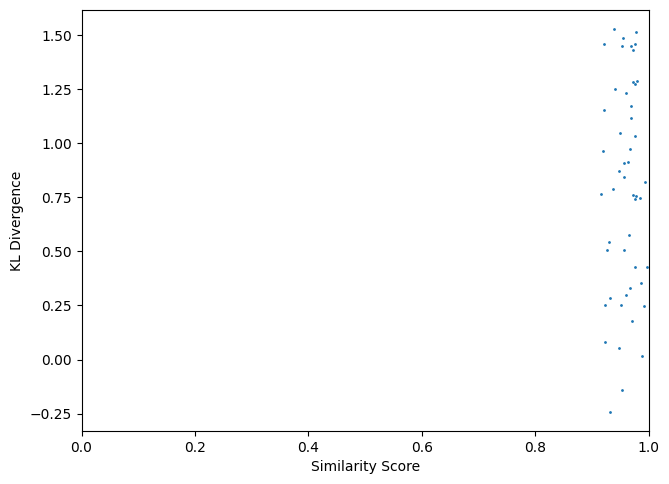

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)
plt.xlim(0,1)

Correctly classified: 6
Incorrectly classified: 44


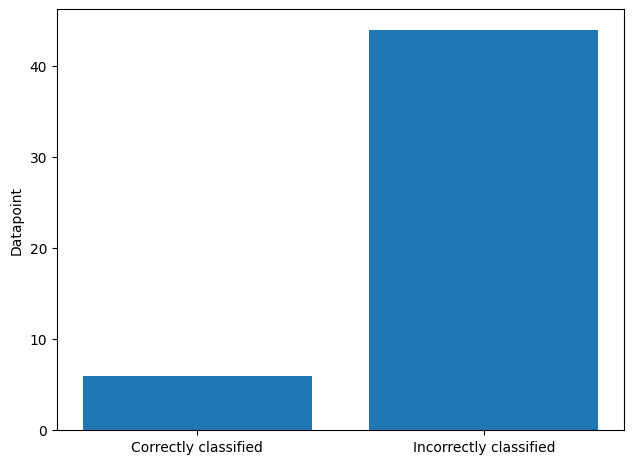

In [ ]:
#Find the best matching genre between ref and gen audio and see if they match

fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("")
ax.set_ylabel("Datapoint")
ax.bar(["Correctly classified", "Incorrectly classified"], [correct, incorrect])
print(f'Correctly classified: {correct}')
print(f'Incorrectly classified: {incorrect}')

##KL Divergence (Random similar)

Plot graph similarity against KL measured

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
import pandas as pd
from datasets import Dataset, Audio
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/Audible-Visual" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/random_similar_subsample.csv')

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/musicgen/random_similar_output'
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"
gen_fnames = os.listdir(gen_audio_subdir)

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

50


In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl_avg = 0
kl = []
correct = 0
incorrect = 0
similarity = []
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)
    ref_genre = ref_audio_dist.argmax(-1).item()

    gen_audio = two_second_window(input['gen_audio']['array'], sample_rate)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)
    gen_genre = gen_audio_dist.argmax(-1).item()

    if gen_genre == ref_genre:
      correct += 1
    else :
      incorrect += 1

    curr_kl = F.kl_div(ref_audio_dist, gen_audio_dist, log_target=True, reduction="batchmean")

    kl.append(curr_kl)
    similarity.append(input['sim_score'])
    kl_avg += curr_kl

kl_avg /= len(audio_dataset)
kl_avg

tensor(0.7945)

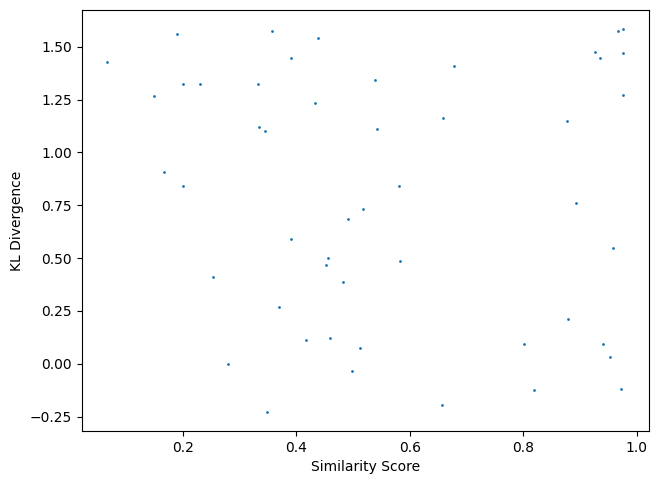

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)

Correctly classified: 13
Incorrectly classified: 37


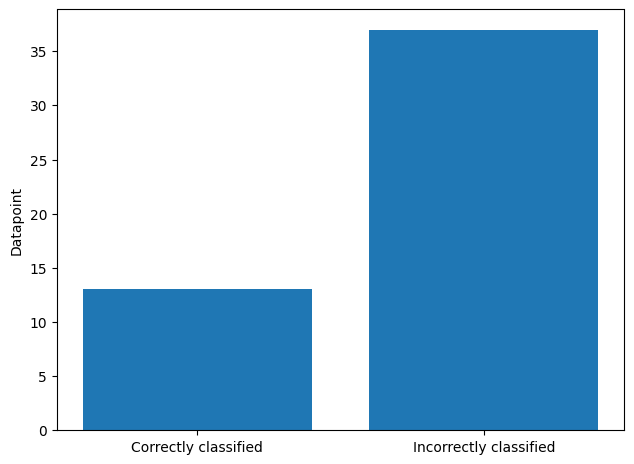

In [ ]:
#Find the best matching genre between ref and gen audio and see if they match
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("")
ax.set_ylabel("Datapoint")
ax.bar(["Correctly classified", "Incorrectly classified"], [correct, incorrect])
print(f'Correctly classified: {correct}')
print(f'Incorrectly classified: {incorrect}')

##KL Divergence (Most similar) with SWR

In [ ]:
!pip install datasets

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline, AutoConfig
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset, Audio
import os
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


sample_rate = 16000
config = AutoConfig.from_pretrained("SeyedAli/Musical-genres-Classification-Hubert-V1")
idx2label = config.id2label
label2idx = config.label2id
pipe = pipeline("audio-classification", model="SeyedAli/Musical-genres-Classification-Hubert-V1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at SeyedAli/Musical-genres-Classification-Hubert-V1 and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'hubert

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

In [ ]:
NEWDSET_PATH = "/content/drive/MyDrive/Colab Notebooks/Project/new_dataset" #Generated audio subdir

pairs_df = pd.read_csv(f'{NEWDSET_PATH}/most_similar_subsample.csv')

In [ ]:
gen_audio_subdir = f'{NEWDSET_PATH}/musicgen/most_similar_output_swr'
gen_fnames = os.listdir(gen_audio_subdir)
ref_audio_subdir = "/content/drive/MyDrive/Colab Notebooks/Project/IMEMNet/cut_audio"

ref_fnames = []
sim_scores = []
for gen_fname in gen_fnames:
  #Get corresponding ref audio name
  top_row = pairs_df[pairs_df.IMG_FILE == gen_fname.split(".")[0]].sort_values(by=["score", "euclid_dist"],ascending=False).iloc[0]
  ref_fnames.append(top_row.WAV_FILE)
  sim_scores.append(top_row.score)

ref_audio_paths = list(map(lambda fname : f'{ref_audio_subdir}/{fname}.wav',ref_fnames))
gen_audio_paths = list(map(lambda fname : f'{gen_audio_subdir}/{fname}',gen_fnames))


audio_dataset = Dataset.from_dict(
    {"gen_audio": gen_audio_paths,
     "ref_audio": ref_audio_paths,
     "sim_score": sim_scores
    }).cast_column(
        "gen_audio", Audio(sampling_rate = sample_rate)
    ).cast_column(
        "ref_audio", Audio(sampling_rate = sample_rate)
    )

print(len(audio_dataset))

50


In [ ]:
def two_second_window(x,sr):
  num_splits = x.size//sr
  idx = np.random.randint(num_splits - 1)
  return x[idx*sr: (idx+2)*sr]

kl_avg = 0
kl = []
correct = 0
incorrect = 0
similarity = []
for input in audio_dataset:
  with torch.no_grad():
    ref_audio = input['ref_audio']['array']
    ref_audio_preprocess = pipe.preprocess(ref_audio)
    ref_audio_logits = pipe._forward(ref_audio_preprocess).logits
    ref_audio_dist = ref_audio_logits.softmax(-1)
    ref_genre = ref_audio_dist.argmax(-1).item()

    gen_audio = two_second_window(input['gen_audio']['array'], sample_rate)
    assert(gen_audio.shape == ref_audio.shape)
    gen_audio_preprocess = pipe.preprocess(gen_audio)
    gen_audio_logits = pipe._forward(gen_audio_preprocess).logits
    gen_audio_dist = gen_audio_logits.softmax(-1)
    gen_genre = gen_audio_dist.argmax(-1).item()

    if gen_genre == ref_genre:
      correct += 1
    else :
      incorrect += 1

    curr_kl = F.kl_div(ref_audio_dist, gen_audio_dist, log_target=True, reduction="batchmean")

    kl.append(curr_kl)
    similarity.append(input['sim_score'])
    kl_avg += curr_kl

kl_avg /= len(audio_dataset)
kl_avg

tensor(0.8066)

(0.0, 1.0)

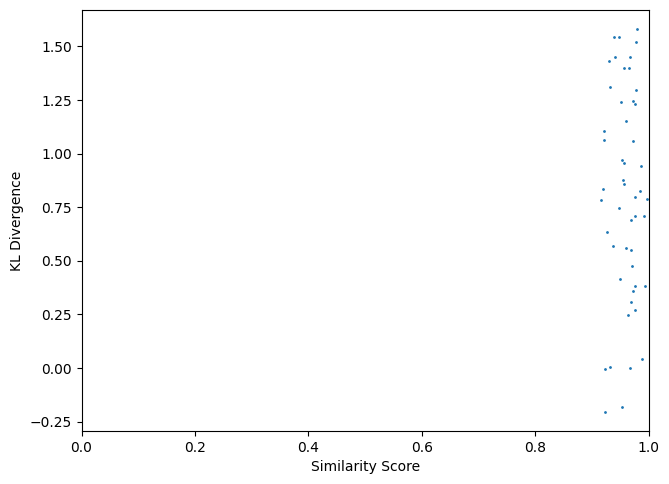

In [ ]:
fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("Similarity Score")
ax.set_ylabel("KL Divergence")
ax.scatter(similarity, kl, s=1)
plt.xlim(0,1)

Correctly classified: 8
Incorrectly classified: 42


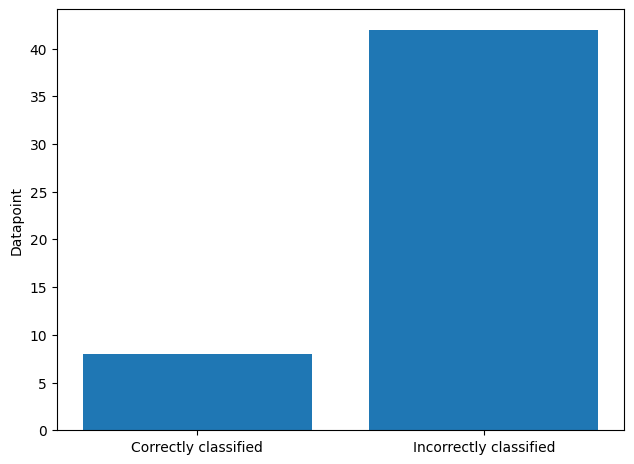

In [ ]:
#Find the best matching genre between ref and gen audio and see if they match

fig,ax = plt.subplots(1)
fig.tight_layout()

ax.set_xlabel("")
ax.set_ylabel("Datapoint")
ax.bar(["Correctly classified", "Incorrectly classified"], [correct, incorrect])
print(f'Correctly classified: {correct}')
print(f'Incorrectly classified: {incorrect}')

##Image->caption->audio embeddings

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
tsne = TSNE(n_components=2, perplexity=14, n_iter=3000, learning_rate="auto")
pca = PCA(n_components=2)

In [ ]:
cmap = {
    "igor": "orchid",
    "kk": "orange",
    "lr": "deepskyblue",
    "m": "powderblue",
    "n": "red",
    "p": "grey",
    "pt": "maroon",
    "rock": "darkkhaki",
    "t": "darkgreen",
    "tn": "lightgreen",
    "distracted_bf_meme": "black",
    "spiderman": "purple",
    "starry_night": "royalblue",
    "the_kiss" : "khaki",
    "woman_in_blue" : "midnightblue"
}

In [ ]:
caption_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/imaudible_caption.csv')
caption_df

,art_style,painting,grounding_emotion,caption,caption_swr
0,ImAudible,igor,NaN,the man 's face looks like he is looking at me,man 's face looking
1,ImAudible,kk,NaN,the sunset is very calming and the colors are ...,sunset calming colors warm inviting
2,ImAudible,lr,NaN,the blue and white colors are calming and soot...,blue white colors calming soothing
3,ImAudible,m,NaN,the grey sky and the dark blue sky make me fee...,grey sky dark blue sky make feel sad
4,ImAudible,n,NaN,the woman looks like she is having a good time,woman good time
5,ImAudible,p,NaN,the colors are very warm and inviting,colors warm inviting
6,ImAudible,pt,NaN,the figures are very detailed and realistic,figures detailed realistic
7,ImAudible,rock,NaN,the man 's face looks like he is looking at me,man 's face looking
8,ImAudible,t,NaN,the trees look like they are glowing in the wind,trees glowing wind
9,ImAudible,tn,NaN,the painting is very abstract and the colors a...,painting abstract colors pleasing


###Image embedding

Create and store csv to where ArtEmis will read and generate a DataLoader

In [ ]:
fnames = list(map(lambda x : x.split(".")[0],os.listdir(f'{PROJECT_PATH}/Artemis/wikiart/ImAudible/')))
art_style = []
painting = []
emotion = []
utterance = []
repetition = []
split = []
tokens = []
tokens_len = []
utterance_spelled = []
tokens_encoded = []
emotion_label = []

for img_fname in fnames:
    art_style.append("ImAudible")
    painting.append(img_fname)
    split.append("test")
    emotion.append("something else") #placeholder
    utterance.append("TEST") #placeholder
    repetition.append(1) #placeholder
    tokens.append(["TEST"]) #placeholder
    tokens_len.append(1)    #placeholder
    utterance_spelled.append("test") #placeholder
    tokens_encoded.append([0]) #placeholder
    emotion_label.append(1) #placeholder

records = {"art_style": art_style,
           "painting": painting,
           "emotion": emotion,
           "utterance": utterance,
           "repetition": repetition,
           "split": split,
           "tokens": tokens,
           "tokens_len": tokens_len,
           "utterance_spelled": utterance_spelled,
           "tokens_encoded": tokens_encoded,
           "emotion_label": emotion_label}
artemis_subsample_df = pd.DataFrame(records)
print(artemis_subsample_df.head())
artemis_subsample_df.to_csv(f'{PROJECT_PATH}/Artemis/preprocessed_data/for_model/artemis_preprocessed.csv')

   art_style            painting         emotion utterance  repetition split  \
0  ImAudible           spiderman  something else      TEST           1  test   
1  ImAudible  distracted_bf_meme  something else      TEST           1  test   
2  ImAudible            the_kiss  something else      TEST           1  test   
3  ImAudible        starry_night  something else      TEST           1  test   
4  ImAudible       woman_in_blue  something else      TEST           1  test   

   tokens  tokens_len utterance_spelled tokens_encoded  emotion_label  
0  [TEST]           1              test            [0]              1  
1  [TEST]           1              test            [0]              1  
2  [TEST]           1              test            [0]              1  
3  [TEST]           1              test            [0]              1  
4  [TEST]           1              test            [0]              1  


KeyboardInterrupt: 

In [ ]:
ARTEMIS_MODEL_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/models/vanilla_SAT_speaker"
SPEAKER_SAVED_ARGS = ARTEMIS_MODEL_PATH + "/config.json.txt"
SPEAKER_CHECKPOINT = ARTEMIS_MODEL_PATH + "/checkpoints/best_model.pt"
SPLIT = "test"
MAX_UTTERANCE_LEN = 10
OUT_PATH="/content/drive/MyDrive/Colab Notebooks/Project/Artemis/inference/output/output.pkl"
SUBSAMPLE_DATA = -1 #if not -1, will subsample the underlying dataset and will annotated only this many images.
CUSTOM_DATA_CSV = None #if you want to annotate your own set of images e.g. adding manual emotional grounding. See code for what this csv should look like.
COMPUTE_NLL = False
SAMPLING_CONFIG_FILE = "/content/artemis/artemis/data/speaker_sampling_configs/selected_hyper_params.json.txt"
IMG2EMO_CHECKPOINT = None
N_WORKERS = 2

In [ ]:
%cd artemis
from artemis.neural_models.resnet_encoder import ResnetEncoder
from artemis.in_out.basics import read_saved_args
%cd ..

In [ ]:
args = read_saved_args(SPEAKER_SAVED_ARGS, override_args=None, verbose=False)
encoder = ResnetEncoder(args.vis_encoder, adapt_image_size=args.atn_spatial_img_size, drop=0).unfreeze()

_, epoch, data_loaders = load_saved_speaker(SPEAKER_SAVED_ARGS, SPEAKER_CHECKPOINT,
                                                  with_data=True, verbose=True)


working_data_loader = data_loaders[SPLIT]
img2emo_clf = None
# removes duplicate images and optionally uses img2emo_clf to create a grounding emotion.
annotate_loader = default_grounding_dataset_from_affective_loader(working_data_loader, img2emo_clf,
                                                                      device, N_WORKERS)

dset = annotate_loader.dataset
loader = DataLoader(dset, num_workers=annotate_loader.num_workers) # batch-size=1

In [ ]:
embs = []
# caption_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/imaudible_caption.csv')
# caption_df.head()
for data in loader:
  with torch.no_grad():
    img = data['image']
    img_emb = encoder(img)
    embs.append(img_emb)

embs = torch.cat(embs, dim=0)
embs = embs.reshape(15, -1)

In [ ]:
z_fit = pca.fit_transform(embs.detach().cpu().numpy())
z_fit.shape

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))

for i in range(15):
  coords = z_fit[i]
  img_info = caption_df.iloc[i]
  ax.scatter(coords[0], coords[1], label=img_info.painting, c=cmap[img_info.painting], s=100)

plt.legend()

###Text embedding

In [ ]:
model = MusicGen.get_pretrained('medium', device=device)
text_encoder = model.lm.condition_provider
descriptions = caption_df.caption.values
descriptions_swr = caption_df.caption_swr.values

/content/audiocraft/audiocraft/models/musicgen.py:80: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-medium
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


state_dict.bin:   0%|          | 0.00/3.68G [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

compression_state_dict.bin:   0%|          | 0.00/236M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
txt_conditions = [ConditioningAttributes(text={'description': description}) for description in descriptions]
for attr in txt_conditions:
  attr.wav['self_wav'] = WavCondition(
                    torch.zeros((1, 1, 1), device=model.device),
                    torch.tensor([0], device=model.device),
                    sample_rate=[model.sample_rate],
                    path=[None])


txt_conditions_swr = [ConditioningAttributes(text={'description': description}) for description in descriptions_swr]
for attr in txt_conditions_swr:
  attr.wav['self_wav'] = WavCondition(
                    torch.zeros((1, 1, 1), device=model.device),
                    torch.tensor([0], device=model.device),
                    sample_rate=[model.sample_rate],
                    path=[None])

In [ ]:
two_step_cfg = model.generation_params['two_step_cfg']
null_conditions = ClassifierFreeGuidanceDropout(p=1.0)(txt_conditions)

def encode(txt_conditions) :
  if two_step_cfg:
      cfg_conditions = (
                      text_encoder(text_encoder.tokenize(txt_conditions)),
                      text_encoder(text_encoder.tokenize(null_conditions)),
                  )
  else:
      conditions = txt_conditions + null_conditions
      tokenized = text_encoder.tokenize(conditions)
      cfg_conditions = text_encoder(tokenized)

  return cfg_conditions

In [ ]:
with torch.no_grad():
  txt_embs = encode(txt_conditions)
  txt_embs = txt_embs['description'][0][0:15]
  txt_embs_swr = encode(txt_conditions_swr)
  txt_embs_swr = txt_embs_swr['description'][0][0:15]

igor and rock has the same text embedding

In [ ]:
x = torch.randn((15,10,1536))
print(txt_embs_swr.shape)
diff = (txt_embs_swr[0] - txt_embs_swr[7]).abs().sum()
print(diff)

torch.Size([15, 10, 1536])
tensor(0., device='cuda:0')


Text embedding distance measure

In [ ]:
import seaborn as sbn

In [ ]:
dists = torch.zeros((15,15))
paintings = []
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

for i in range(15):

  paintings.append(caption_df.iloc[i].painting)
  for j in range(15):

    if i == j:
      continue

    cost = cos(txt_embs_swr[i], txt_embs_swr[j])
    cost = torch.mean(cost,dim=0)
    dists[i][j] = cost.cpu()

# txt_embs_swr = txt_embs_swr['description'][0][0:15]
paintings = list(map(lambda x : x.replace("_", " "), paintings))

Set igor and rock to 1

In [ ]:
dists[0,7] = 1
dists[7,0] = 1

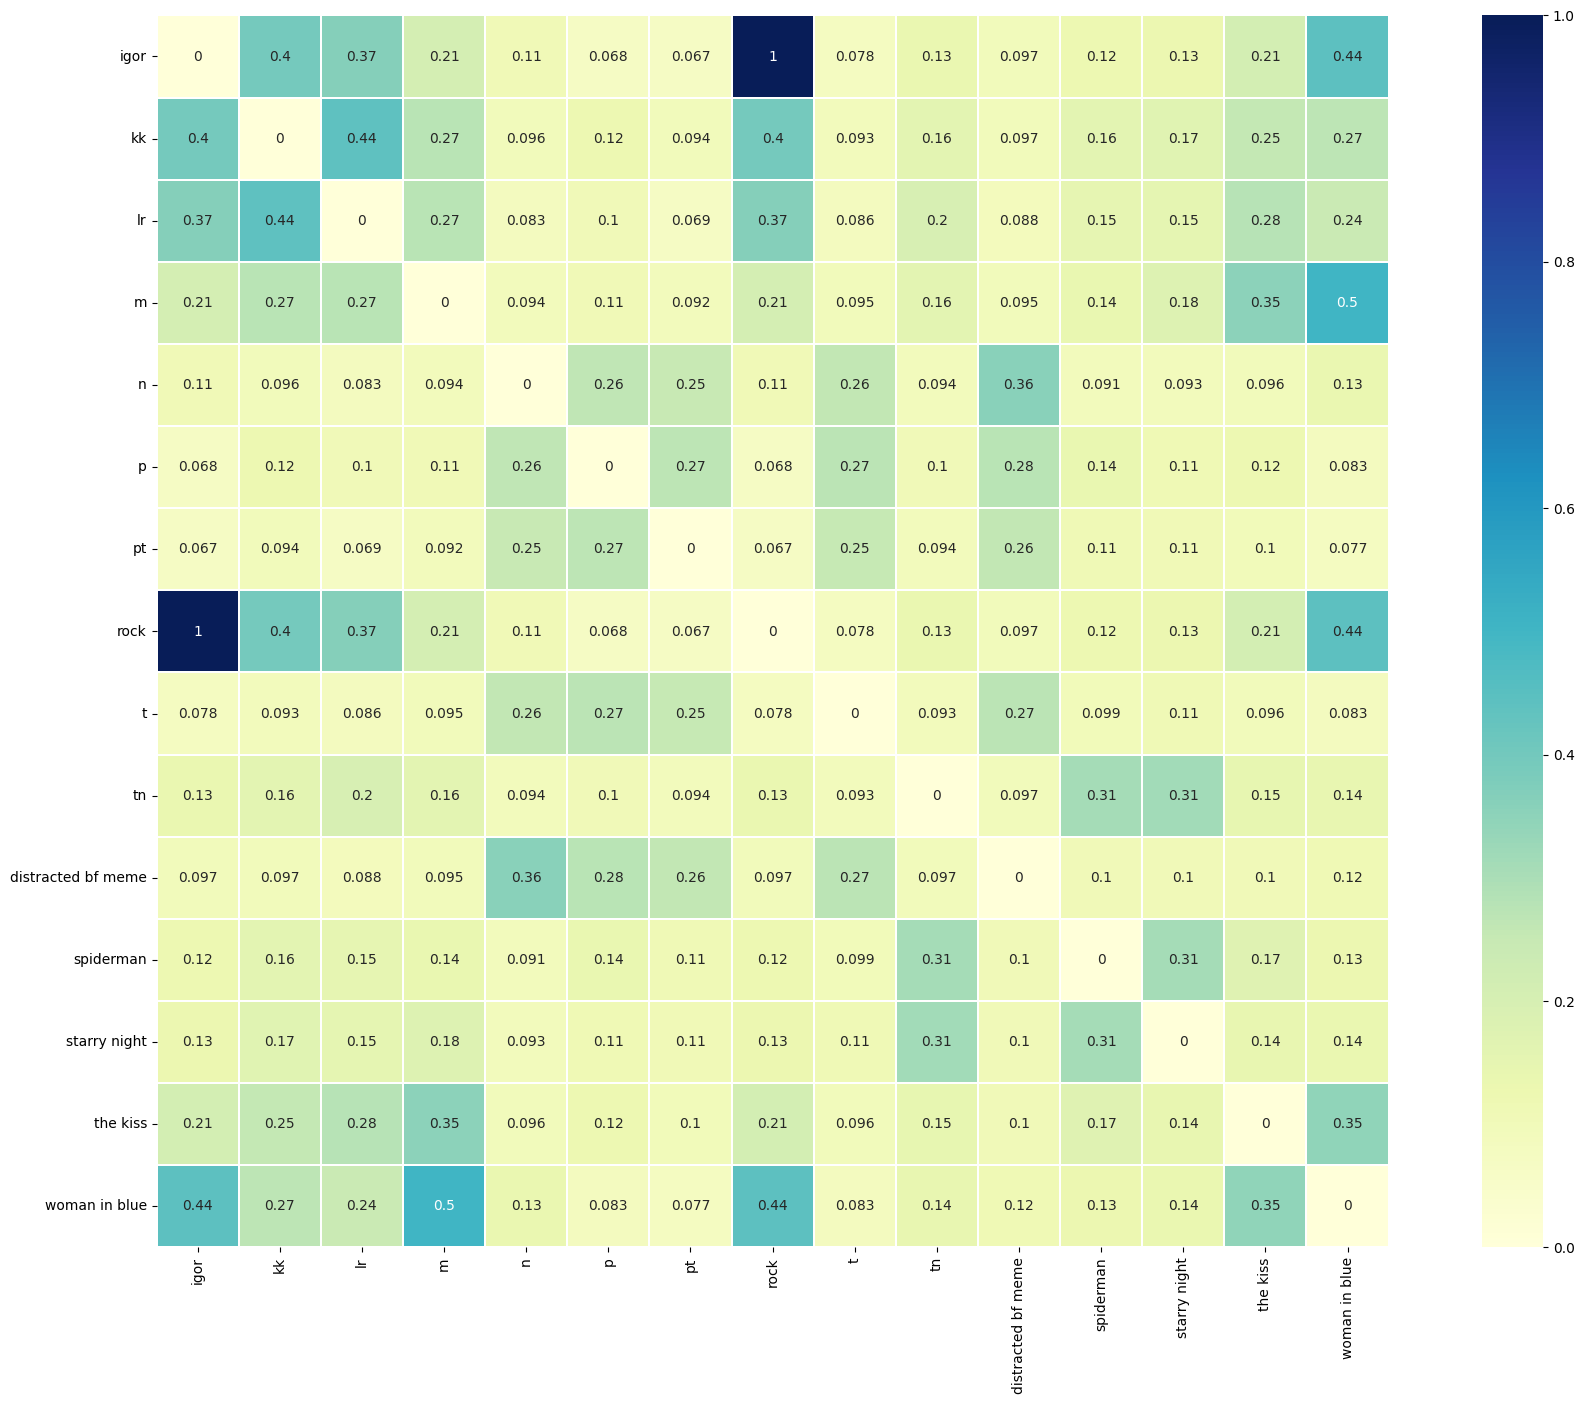

In [ ]:
fig, ax = plt.subplots(figsize=(24, 16))
sbn.heatmap(dists, annot=True, square=True, linewidths=0.1, cmap="YlGnBu", xticklabels=paintings, yticklabels=paintings,ax=ax)
plt.show()

In [ ]:
torch.save(dists, './dists.pt')

In [ ]:
# txt_embs = txt_embs.reshape(15,-1)
# emb_fit = pca.fit_transform(txt_embs.detach().cpu().numpy())

# txt_embs_swr = txt_embs_swr.reshape(15,-1)
# emb_fit_swr = pca.fit_transform(txt_embs_swr.detach().cpu().numpy())

[ 20.71     -18.854578]
[6.161158  3.2715425]
[4.6462145 7.35193  ]
[12.946415 22.667631]
[-12.9766035  -6.895411 ]
[-15.629585   -1.2213726]
[-15.192371   -2.8755784]
[ 20.70999  -18.854584]
[-14.729388   -3.8507304]
[-9.283895    0.16236757]
[-14.500131   -5.9301515]
[-10.9494705   1.5495625]
[-10.090737     0.96253234]
[11.771179 29.256952]
[26.407225  -6.7400975]


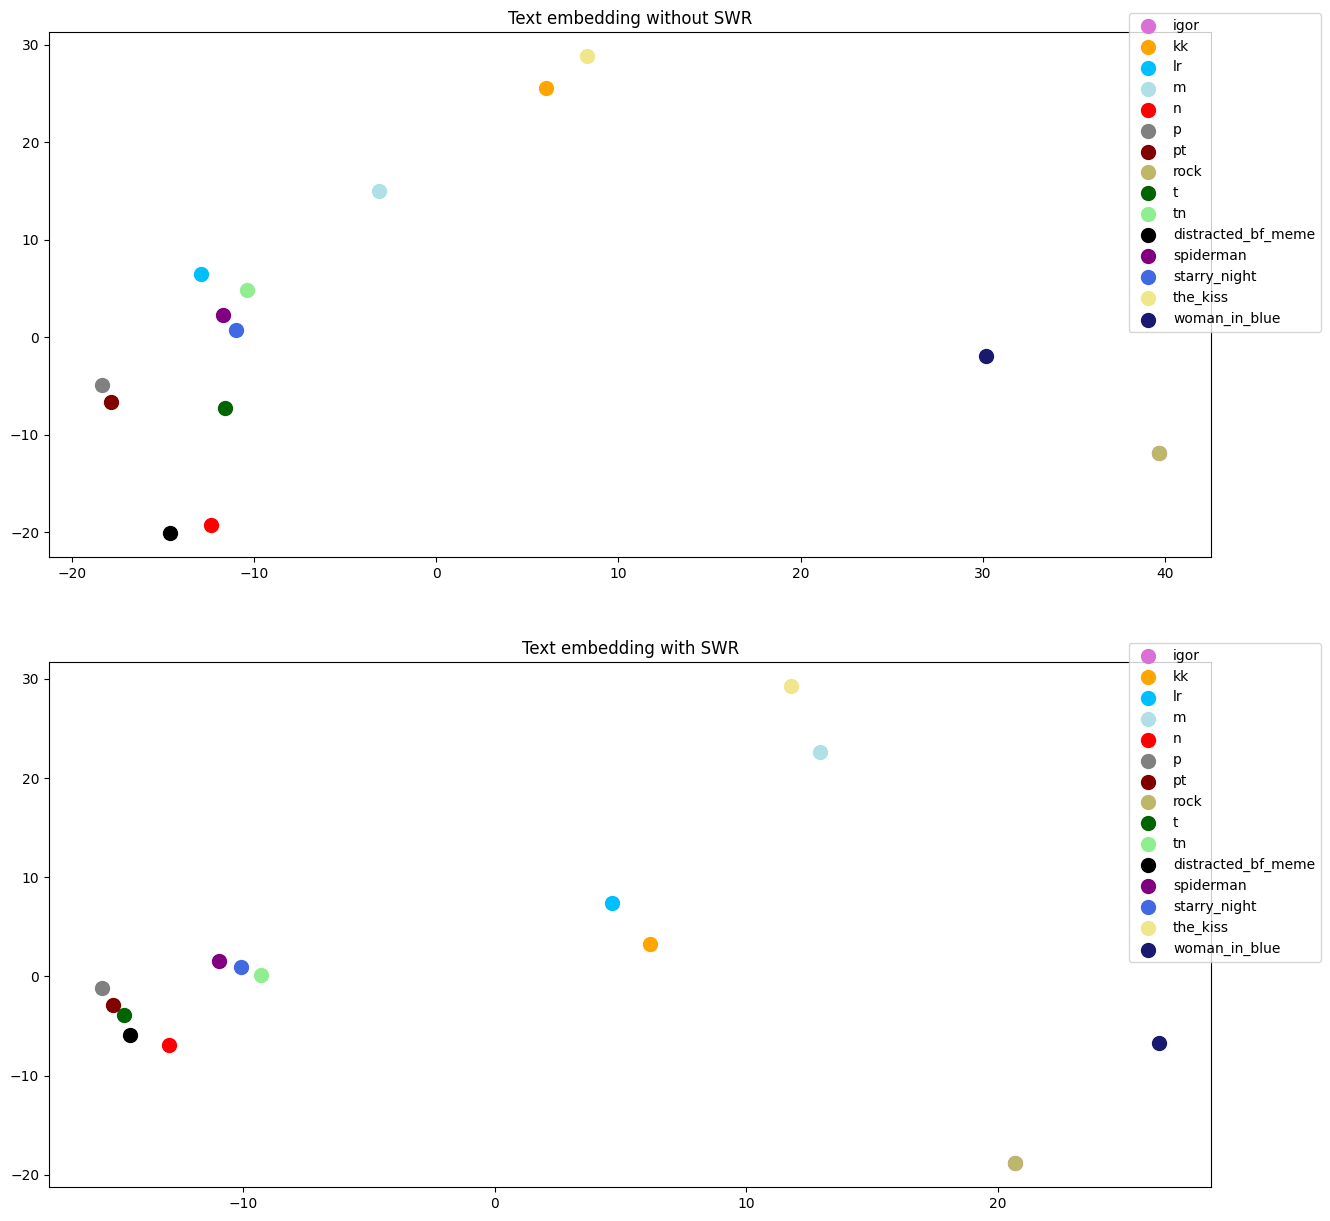

In [ ]:
fig, ax = plt.subplots(2, figsize=(15,15))

for i in range(15):

  coords = emb_fit[i]
  coords_swr = emb_fit_swr[i]

  img_info = caption_df.iloc[i]
  print(coords_swr)
  ax[0].scatter(coords[0], coords[1], label=img_info.painting, c=cmap[img_info.painting], s=100)
  ax[1].scatter(coords_swr[0], coords_swr[1], label=img_info.painting, c=cmap[img_info.painting], s=100)

ax[0].set_title("Text embedding without SWR")
ax[0].legend(bbox_to_anchor=(1.1, 1.05))
ax[1].set_title("Text embedding with SWR")
ax[1].legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

###Audio embedding

In [ ]:
model = MusicGen.get_pretrained('medium', device=device)
encodec = model.compression_model

/content/audiocraft/audiocraft/models/musicgen.py:80: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-medium
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
audio_files = os.listdir(f'/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/audio')

In [ ]:
batched_x = []
wav_embs = []

for rec in caption_df.iterrows():
  audio_file = rec[1].painting
  x,sr = sf.read(f'/content/drive/MyDrive/Colab Notebooks/Project/ImAudible/audio/{audio_file}.wav')
  # print(f'{audio_file} with sample rate {sr}')
  x, scale = encodec.preprocess(x)
  batched_x.append(torch.tensor(x,dtype=torch.float32).reshape(1,1,-1))

batched_x = torch.cat(batched_x, dim=0).to(device)
batched_x.shape

torch.Size([15, 1, 512000])

In [ ]:
with torch.no_grad():
  wav_embs = encodec.encoder(batched_x)
wav_embs = wav_embs.reshape(15,-1)

In [ ]:
wav_embs.shape

torch.Size([15, 102400])

In [ ]:
wav_fit = pca.fit_transform(wav_embs.detach().cpu().numpy())
wav_fit.shape

(15, 2)

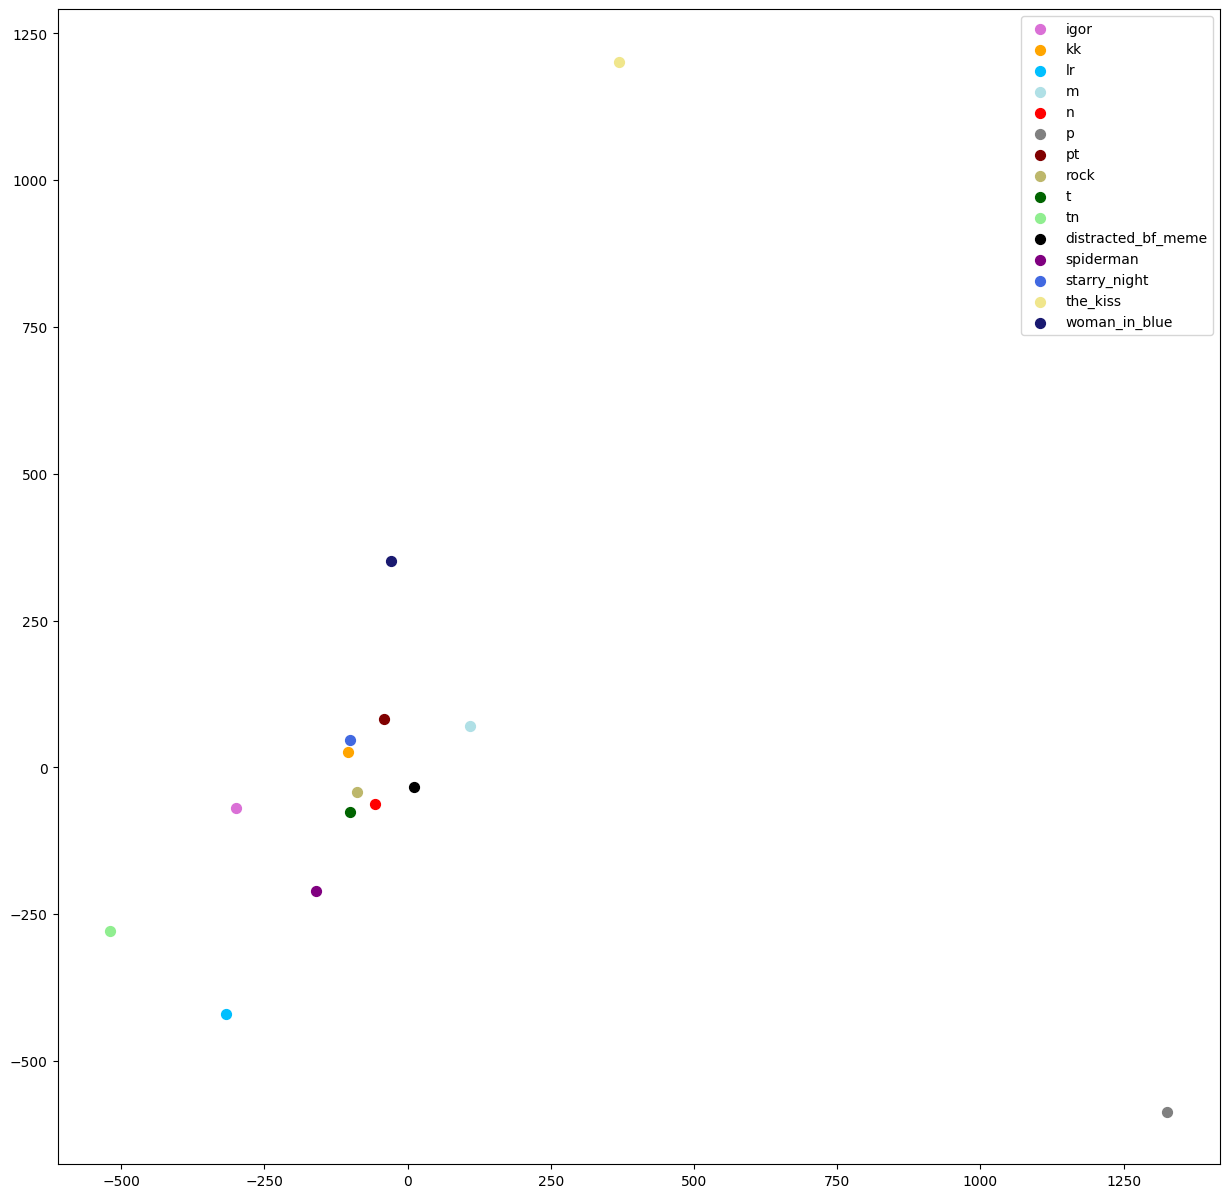

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))

for rec in caption_df.iterrows():
  name = rec[1].painting
  coords = wav_fit[rec[0]]
  ax.scatter(coords[0], coords[1], label=name, c=cmap[name],s=50)

plt.legend()